In [1]:
import pandas as pd
from sklearn.linear_model import  LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import category_encoders as ce
from sklearn import preprocessing
import random
import numpy as np

In [2]:
def dataset_to_Xandy(dataset, target_variable):
    X = dataset.loc[:, dataset.columns != target_variable]
    y = dataset.loc[:, dataset.columns == target_variable]
    return X, y

def standardise(X):
    return (X - np.mean(X)) / np.std(X)

def split_dataset(X,y, randomlist, not_in_randomlist):
    X_train = X.iloc[randomlist,:]
    y_train = y.iloc[randomlist,:]
    X_test = X.iloc[not_in_randomlist,:]
    y_test = y.iloc[not_in_randomlist,:]
    return X_train.to_numpy(), y_train.to_numpy(), X_test.to_numpy(), y_test.to_numpy()

def plot_conf_matrix(confusion_matrix,encoding):
    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix)
    cm_display.plot()
    plt.title('Confusion matrix for '+str(encoding)+' encoding')
    plt.show()  

def calc_conf_matrix(X,y,randomlist,not_in_randomlist,classifier):
    X_train, y_train, X_test, y_test = split_dataset(X,y,randomlist, not_in_randomlist)
    
    # depending on what the user inputs
    if classifier == 'logistic':
        model = LogisticRegression(penalty = 'none')  
    elif classifier == 'kNN':
        model = KNeighborsClassifier()  
    elif classifier == 'decision_tree':
        model = DecisionTreeClassifier()
    else:
        assert('Classifier unknown')
    
    # perform fitting of the model 
    model.fit(X_train, y_train.reshape(-1,))  
    y_predicted = model.predict(X_test) 
    
    # computing confusion matrix, fpr, tpr, auc
    matrix = metrics.confusion_matrix(y_test, y_predicted)
    fpr, tpr, _ = metrics.roc_curve(y_test, y_predicted)
    area_roc = metrics.auc(fpr, tpr)
    return matrix[0,0], matrix[0,1], matrix[1,0], matrix[1,1], area_roc

def plot_boxplots_confusion(confusion_matrix,entry,which_dataset,classifier, how_to_bin, nr_bins):
    dictionary = {}
    for key in confusion_matrix:
        dictionary[key] = confusion_matrix[key][entry]
    fig, ax = plt.subplots()
    ax.boxplot(dictionary.values())
    ax.set_xticklabels(dictionary.keys())
    if entry == '00':
        name = 'true negative'
    elif entry == '01':
        name = 'false positive'
    elif entry == '10':
        name = 'false negative'
    elif entry == '11':
        name = 'true positive'
    elif entry == 'accuracy':
        name = 'accuracy'
    elif entry == 'auc':
        name = 'area under ROC curve'
    plt.title('Boxplots of ' + name +' \n Test Size '+ str(out_of)+'\n Dataset:'+which_dataset+'\n Classifier:'+classifier+'\n Binning:'+str(how_to_bin)+', h = '+str(nr_bins))
    plt.show()    
    

def put_in_bins(data, how_many_bins, how_to_bin):
    mi = min(data)
    ma = max(data)
    if how_to_bin =='cons_std':
        bin_size = how_many_bins * np.std(data)
        start = (mi + ma)/2

        bins_right = [start]
        current_right = 1.0 * start
        while current_right  < ma:
            current_right += bin_size
            bins_right.append(current_right)

        bins_left = []
        current_left = 1.0 * start
        while current_left  > mi:
            current_left -= bin_size
            bins_left.append(current_left)

        bins = np.concatenate((bins_left[::-1],bins_right))
    elif how_to_bin =='fixed_number':
        bins = np.linspace(mi-0.00000001, ma+0.00000001,how_many_bins)
    else:
        assert('Way of binning unknown')
    digitized = np.digitize(data,bins)
    midpoints_bins = (bins[:len(bins)-1] + bins[1:])/2
    new_data = midpoints_bins[digitized-1]
    return new_data
 
def pick_only_some(df, target_variable, number):
    df0 = df.loc[df[target_variable] ==0 ]
    df1 = df.loc[df[target_variable] ==1 ]
    how_many_0 = df0.shape[0]
    how_many_1 = df1.shape[0]
    random_indices = random.sample(range(0, how_many_0), how_many_0 - number)
    df0 = df0.drop(df0.index[random_indices])
    random_indices = random.sample(range(0, how_many_1), how_many_1 - number)
    df1 = df1.drop(df1.index[random_indices])
    df = pd.concat([df0, df1])
    return df

def generating_test_data(how_many_times_repeat, iterations, mu1, sigma1, mu2, 
                         sigma2, plot_classes = False):

    dim = len(mu1)
    testing_data=[]
    belonging_classes=[]

    for repeat in range(how_many_times_repeat):

        random_simulation = np.zeros((iterations,dim))
        which_class_list = np.zeros((iterations,))
        
        for itera in range(iterations):

            which_normal = random.randint(0,1)
            if dim == 1:
                if which_normal == 0:
                    random_simulation[itera,] = np.random.normal(mu1, sigma1)
                else:
                    random_simulation[itera,] = np.random.normal(mu2, sigma2)
            else:
                if which_normal == 0:
                    random_simulation[itera,] = np.random.multivariate_normal(mu1, sigma1)
                else:
                    random_simulation[itera,] = np.random.multivariate_normal(mu2, sigma2)
            which_class_list[itera,] = which_normal
        
        testing_data.append(random_simulation)
        belonging_classes.append(which_class_list)
      
    
    return testing_data, belonging_classes

In [3]:
which_dataset = 'Simulated Dataset'

e1 = [0,0]
e2 = [1,1]
std1 = np.array(([1,0],[0,1]))
std2 = np.array(([1,0],[0,1]))
how_many_rows = 100

testing_data, belonging_classes = generating_test_data(1, how_many_rows, e1, std1,e2, std2)
d = {'feature1':testing_data[0][:,0], 'feature2':testing_data[0][:,1],'target':belonging_classes[0]}
df = pd.DataFrame(data=d)

continuous_variables=['feature1', 'feature2']
target_variable = 'target'
categorical_variables = []
df.head()





,feature1,feature2,target
0,1.253109,-0.259442,1.0
1,-0.094772,0.120439,0.0
2,0.961216,1.347488,1.0
3,-1.081963,-1.979096,0.0
4,0.631697,0.213215,1.0


In [4]:
######### AIRLINE DATASET  

# df = pd.read_csv('datasets/airline_dataset.csv')
# categorical_variables = ['MONTH','DAY_OF_WEEK','DEP_TIME_BLK','DISTANCE_GROUP','SEGMENT_NUMBER','CARRIER_NAME', 'DEPARTING_AIRPORT','PREVIOUS_AIRPORT'] # Putting in this all the categorical columns
# target_variable = 'DEP_DEL15' # Making sure the name of the target variable is known

# df0 = df.loc[df[target_variable] ==0 ]
# df1 = df.loc[df[target_variable] ==1 ]
# how_many_0 = df0.shape[0]
# how_many_1 = df1.shape[0]
# random_indices = random.sample(range(0, how_many_0), how_many_0 - 4000)
# df0 = df0.drop(df0.index[random_indices])
# random_indices = random.sample(range(0, how_many_1), how_many_1 - 4000)
# df1 = df1.drop(df1.index[random_indices])
# df = pd.concat([df0, df1])

In [5]:
########### WINE QUALITY
# df = pd.read_csv('datasets/wine_dataset.csv')
# target_variable = 'quality' # Making sure the name of the target variable is known
# df[target_variable] = df[target_variable].replace(['bad'], 0)
# df[target_variable] = df[target_variable].replace(['good'], 1)

# which_dataset = 'Wine Quality'

# categorical_variables = [] # Putting in this all the categorical columns
# continuous_variables = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
#        'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
#        'pH', 'sulphates', 'alcohol']


In [6]:
# ########### BODY SIGNAL SMOKING
# which_dataset = 'Body Signals for Smoking'
# df = pd.read_csv('datasets/bodysignal_smoking.csv')
# df = df.drop(['ID','oral'],axis = 1)

# categorical_variables = [] # Putting in this all the categorical columns
# target_variable = 'smoking' # Making sure the name of the target variable is known

# binary_cols = ['tartar','dental caries','hearing(right)','hearing(left)','gender']
# continuous_variables = list(set(df.keys()) - set(categorical_variables + binary_cols + [target_variable]))
# ### make sure binary variables are 0 and 1
# labelencoder = ce.OrdinalEncoder(cols=binary_cols)
# df = labelencoder.fit_transform(df)

In [7]:
# which_dataset = 'Crop'
# df = pd.read_csv('datasets/crop_dataset.txt')
# target_variable = 'label'
# continuous_variables = list(set(df.keys()) - set([target_variable]))
# categorical_variables = []

# df = df[ (df['label'] == 1) | (df['label'] == 5)]
# df[df['label'] == 5 ] = 0 #### 0 means oats, 1 means corn

# df = pick_only_some(df, target_variable, 4000)
# df = df.reset_index(drop=True)

In [8]:
classifier = 'kNN' 
how_to_bin = 'fixed_number'
nr_bins = 100

In [9]:
categ = len(categorical_variables)
cont = len(continuous_variables)

In [10]:
###### START - PREPROCESSING

size = df.shape[0] # size of the dataset

# Seeing if they are indeed categorical
if categ == 0:
    print('No Categorical Variables')

No Categorical Variables


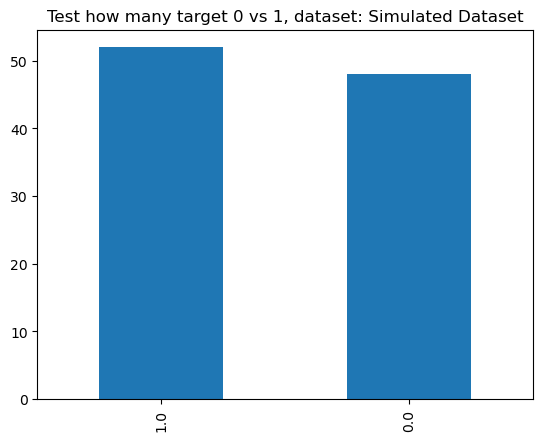

In [11]:
# Seeing if the data is balanced
plt.figure()
df[target_variable].value_counts().plot(kind='bar')
plt.title('Test how many target 0 vs 1, dataset: '+ which_dataset)
plt.show()

In [12]:
df.head()

,feature1,feature2,target
0,1.253109,-0.259442,1.0
1,-0.094772,0.120439,0.0
2,0.961216,1.347488,1.0
3,-1.081963,-1.979096,0.0
4,0.631697,0.213215,1.0


In [13]:
# If all columns are continuous, we bin them columns
binned_df = df.copy()
for col in continuous_variables:
    if how_to_bin =='fixed_number':
        binned_df[col] = standardise(put_in_bins(df[col], nr_bins, how_to_bin))
    elif how_to_bin =='cons_std':
        binned_df[col] = standardise(put_in_bins(df[col], nr_bins, how_to_bin))
binned_df.head()

,feature1,feature2,target
0,0.588423,-0.714234,1.0
1,-0.534708,-0.365584,0.0
2,0.344264,0.779979,1.0
3,-1.316017,-2.258254,0.0
4,0.100105,-0.265970,1.0


In [14]:
# We standardise original dataset
for cont_col in continuous_variables:
    df[cont_col] = standardise(df[cont_col])
df.head()

,feature1,feature2,target
0,0.590088,-0.696984,1.0
1,-0.514033,-0.351460,0.0
2,0.350983,0.764614,1.0
3,-1.322693,-2.261111,0.0
4,0.081057,-0.267075,1.0


In [15]:
how_many_iterations = 10 # how many CV folds

# initialising confusion matrices

confusion_matrix = {}
confusion_matrix['not binned'] =  {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}
confusion_matrix['binned'] =  {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}
confusion_matrix['simple'] =   {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}
confusion_matrix['onehot'] =  {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}
confusion_matrix['target'] =   {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}
confusion_matrix['effect'] =  {'00':np.zeros((how_many_iterations,)),'10':np.zeros((how_many_iterations,)),'01':np.zeros((how_many_iterations,)),'11':np.zeros((how_many_iterations,)),
                               'accuracy':np.zeros((how_many_iterations,)), 'auc':np.zeros((how_many_iterations,))}

out_of = size - 4 * size // 5

In [16]:
for iteration in range(how_many_iterations):
    
    # Randomising the CV fold
    randomlist = random.sample(range(0, size),  4 * size// 5)
    not_in_randomlist = list(set(range(0,size)) - set(randomlist))
 
    
    ### PREDICTION WITHOUT CONT COLUMNS ARE NOT BINNED
    
    X, y =  dataset_to_Xandy(df, target_variable)
    m0, m1, m2, m3, auc = calc_conf_matrix(X,y,randomlist,not_in_randomlist, classifier)
    confusion_matrix['not binned']['00'][iteration] = m0
    confusion_matrix['not binned']['01'][iteration] = m1
    confusion_matrix['not binned']['10'][iteration] = m2
    confusion_matrix['not binned']['11'][iteration] = m3
    confusion_matrix['not binned']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['not binned']['auc'][iteration] = auc
    
    
    ### PREDICTION CONT COLUMNS ARE BINNED
    
    X, y =  dataset_to_Xandy(binned_df, target_variable)
    m0, m1, m2, m3, auc = calc_conf_matrix(X,y,randomlist,not_in_randomlist, classifier)
    confusion_matrix['binned']['00'][iteration] = m0
    confusion_matrix['binned']['01'][iteration] = m1
    confusion_matrix['binned']['10'][iteration] = m2
    confusion_matrix['binned']['11'][iteration] = m3
    confusion_matrix['binned']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['binned']['auc'][iteration] = auc
    
    
    ### PREDICTION CONT COLUMNS ARE BINNED + SIMPLE ENCODING
    
    labelencoder = ce.OrdinalEncoder(cols=continuous_variables)
    new_df = labelencoder.fit_transform(binned_df)
        
    X,y =  dataset_to_Xandy(new_df, target_variable)    
    m0, m1, m2, m3, auc = calc_conf_matrix(X,y,randomlist,not_in_randomlist, classifier)
    confusion_matrix['simple']['00'][iteration] = m0
    confusion_matrix['simple']['01'][iteration] = m1
    confusion_matrix['simple']['10'][iteration] = m2
    confusion_matrix['simple']['11'][iteration] = m3
    confusion_matrix['simple']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['simple']['auc'][iteration] = auc
  
    
    
    ### PREDICTION CONT COLUMNS ARE BINNED + ONE HOT ENCODING
    
    encoder = ce.OneHotEncoder(cols=continuous_variables,use_cat_names=True)
    new_df = encoder.fit_transform(binned_df)
        
    X,y =  dataset_to_Xandy(new_df, target_variable)
    m0, m1, m2, m3, auc = calc_conf_matrix(X,y,randomlist,not_in_randomlist, classifier)
    confusion_matrix['onehot']['00'][iteration] = m0
    confusion_matrix['onehot']['01'][iteration] = m1
    confusion_matrix['onehot']['10'][iteration] = m2
    confusion_matrix['onehot']['11'][iteration] = m3
    confusion_matrix['onehot']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['onehot']['auc'][iteration] = auc
    
    
    
    #### PREDICTION CONT COLUMNS ARE BINNED + EFFECT ENCODING
    
    encoder = ce.sum_coding.SumEncoder(cols=continuous_variables,verbose=False)
    new_df = encoder.fit_transform(binned_df)

    X,y =  dataset_to_Xandy(new_df, target_variable)
    m0, m1, m2, m3, auc = calc_conf_matrix(X,y,randomlist,not_in_randomlist, classifier)
    confusion_matrix['effect']['00'][iteration] = m0
    confusion_matrix['effect']['01'][iteration] = m1
    confusion_matrix['effect']['10'][iteration] = m2
    confusion_matrix['effect']['11'][iteration] = m3
    confusion_matrix['effect']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['effect']['auc'][iteration] = auc
    
    
    
    ##### PREDICTION CONT COLUMNS ARE BINNED + TARGET ENCODING
    
    TE_encoder = ce.TargetEncoder(cols=continuous_variables)
    new_df = TE_encoder.fit_transform(binned_df, binned_df[target_variable])
        
    X,y =  dataset_to_Xandy(new_df, target_variable)
    m0, m1, m2, m3, auc = calc_conf_matrix(X,y,randomlist,not_in_randomlist, classifier)
    confusion_matrix['target']['00'][iteration] = m0
    confusion_matrix['target']['01'][iteration] = m1
    confusion_matrix['target']['10'][iteration] = m2
    confusion_matrix['target']['11'][iteration] = m3
    confusion_matrix['target']['accuracy'][iteration] = (m0+m3) / out_of
    confusion_matrix['target']['auc'][iteration] = auc

/Users/roatisiris/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/roatisiris/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

/Users/roatisiris/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/roatisiris/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

/Users/roatisiris/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/roatisiris/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will n

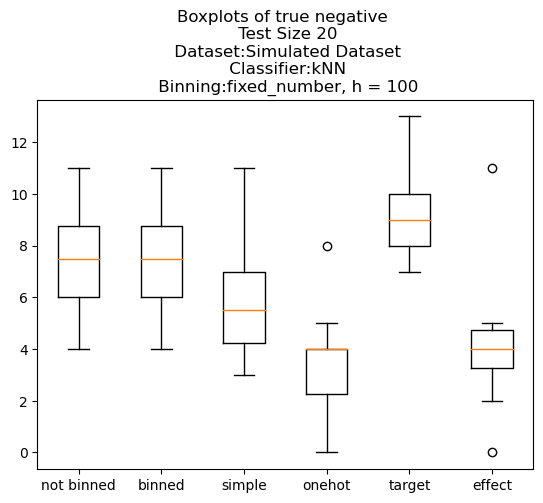

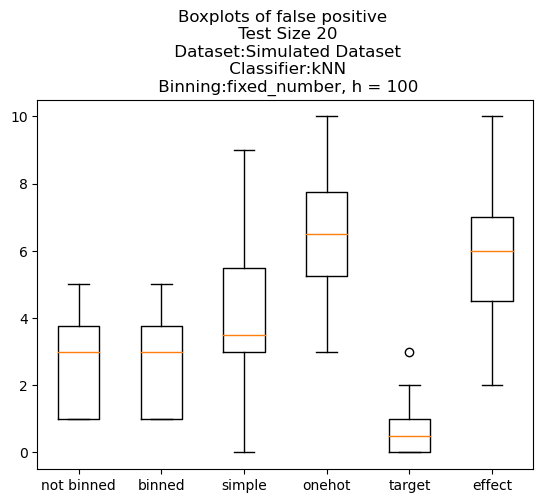

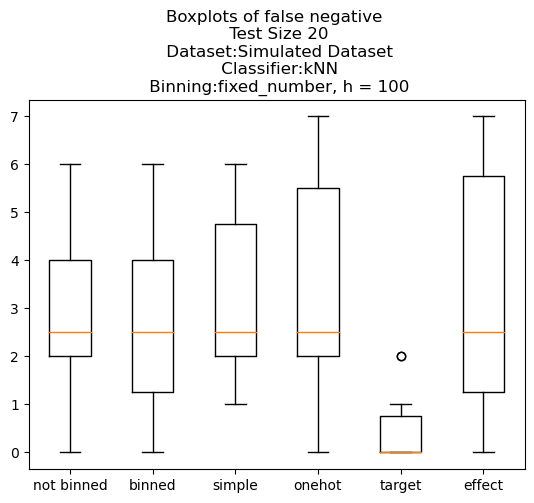

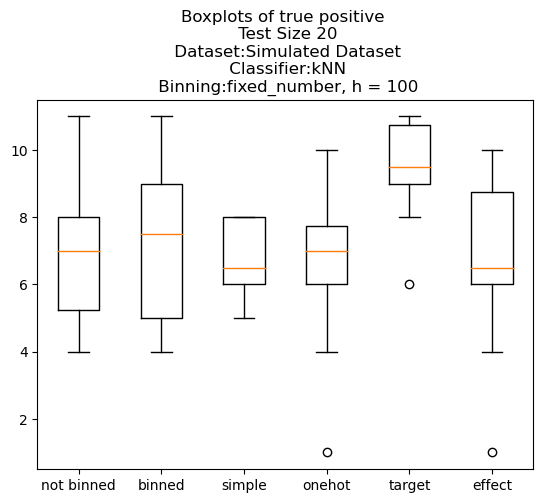

In [17]:
plot_boxplots_confusion(confusion_matrix, '00', which_dataset, classifier, how_to_bin, nr_bins)
plot_boxplots_confusion(confusion_matrix, '01', which_dataset, classifier, how_to_bin, nr_bins)
plot_boxplots_confusion(confusion_matrix, '10', which_dataset, classifier, how_to_bin, nr_bins)
plot_boxplots_confusion(confusion_matrix, '11', which_dataset, classifier, how_to_bin, nr_bins)

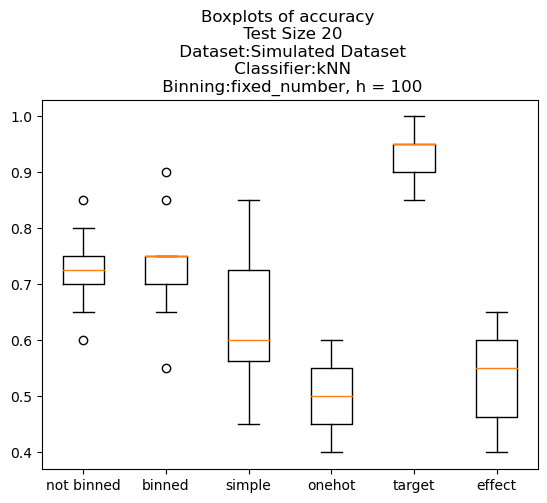

In [18]:
plot_boxplots_confusion(confusion_matrix, 'accuracy', which_dataset, classifier, how_to_bin, nr_bins)

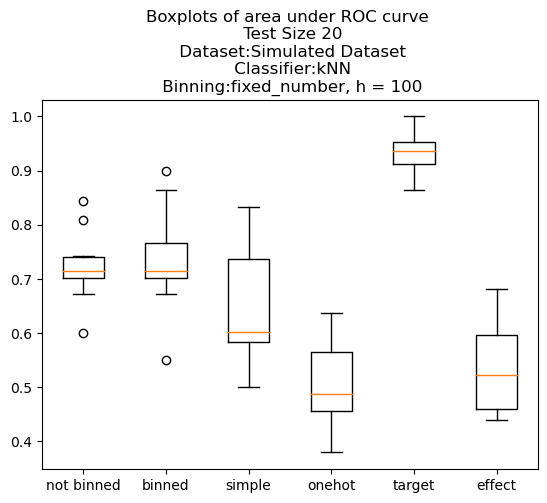

In [19]:
plot_boxplots_confusion(confusion_matrix, 'auc', which_dataset, classifier, how_to_bin, nr_bins)